## Fitted Q-iteration

Welcome to your 3rd assignment in Reinforcement Learning in Finance. In this exercise you will take the most popular extension of Q-Learning to a batch RL setting called Fitted Q-Iteration.

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- When encountering **```# dummy code - remove```** please replace this code with your own 

**After this assignment you will:**
 - Setup inputs for batch-RL model
 - Implement Fitted Q-Iteration

Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [131]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random

import sys

sys.path.append("..")
import grading

import time
import matplotlib.pyplot as plt

In [132]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="0jn7tioiEeiBAA49aGvLAg" 
all_parts=["wrZFS","yqg6m","KY5p8","BsRWi","pWxky"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [133]:
COURSERA_TOKEN = 'oknaqD2mu3m3vipk' # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = 'wudig159@163.com' # the email

## Parameters for MC simulation of stock prices

In [134]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity
T = 6        # number of time steps

N_MC = 10000 # 10000 # 50000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

Based on simulated stock price $S_t$ paths, compute state variable $X_t$ by the following relation.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Also compute

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plots of 5 stock price $S_t$ and state variable $X_t$ paths are shown below.


Time Cost: 0.07647490501403809 seconds


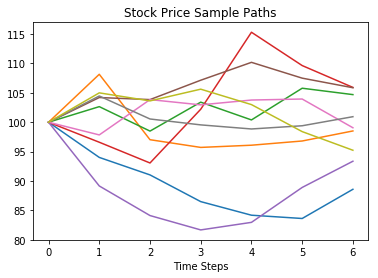

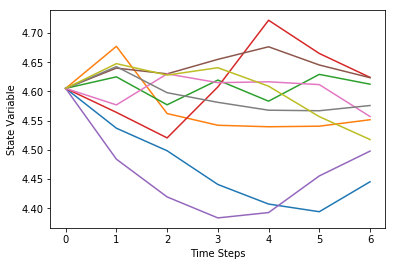

In [135]:
# make a dataset 

starttime = time.time()
np.random.seed(42) # Fix random seed
# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

Define function *terminal_payoff* to compute the terminal payoff of a European put option.

$$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [136]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K-ST, 0)
    return payoff

##  Define spline basis functions  

X.shape =  (10000, 7)
X_min, X_max =  4.05752797076 5.16206652917
Number of points k =  17


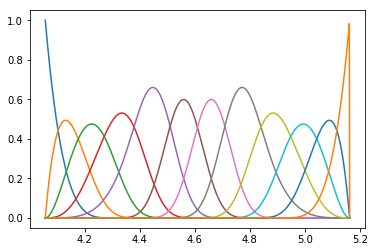

In [137]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
f = plt.figure()

# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [138]:
type(basis)

bspline.bspline.Bspline

In [139]:
X.values.shape

(10000, 7)

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [140]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

# fill it, expand function in finite dimensional space
# in neural network the basis is the neural network itself
t_0 = time.time()
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])
 
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (7, 10000, 12)
Computational time: 15.55447006225586 seconds


In [141]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)

In [142]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(7, 10000, 12)
17


## Dynamic Programming solution for QLBS 

The MDP problem in this case is to solve the following Bellman optimality equation for the action-value function.

$$Q_t^\star\left(x,a\right)=\mathbb{E}_t\left[R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\space|\space X_t=x,a_t=a\right],\space\space t=0,...,T-1,\quad\gamma=e^{-r\Delta t}$$

where $R_t\left(X_t,a_t,X_{t+1}\right)$ is the one-step time-dependent random reward and $a_t\left(X_t\right)$ is the action (hedge).

Detailed steps of solving this equation by Dynamic Programming are illustrated below.

With this set of basis functions $\left\{\Phi_n\left(X_t^k\right)\right\}_{n=1}^N$, expand the optimal action (hedge) $a_t^\star\left(X_t\right)$ and optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ in basis functions with time-dependent coefficients.
$$a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T−1,...,0$. 

Coefficients for expansions of the optimal action $a_t^\star\left(X_t\right)$ are solved by

$$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

where $\mathbf A_t$ and $\mathbf B_t$ are matrix and vector respectively with elements given by

$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$

Define function *function_A* and *function_B* to compute the value of matrix $\mathbf A_t$ and vector $\mathbf B_t$.

## Define the option strike and risk aversion parameter

In [143]:
risk_lambda = 0.001 # 0.001 # 0.0001            # risk aversion
K = 100 # 

# Note that we set coef=0 below in function function_B_vec. This correspond to a pure risk-based hedging

## Part 1: Implement functions to compute optimal hedges

**Instructions:** Copy-paste implementations from the previous assignment, i.e. QLBS as these are the same functions

In [144]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # A_mat = your code goes here ...
    X_mat = data_mat[t, :, :]
    num_basis_func = X_mat.shape[1] 
    hat_dS2 = (delta_S_hat.loc[:, t] ** 2).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_func)
    
    ### END CODE HERE ###
    return A_mat

def function_B_vec(t,
                   Pi_hat, 
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    
    Return:
    B_vec - np.array() of dimension num_basis x 1
    """
    # coef = 1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    coef = 0. # keep it
    
    ### START CODE HERE ### (≈ 3-4 lines of code)
    # B_vec = your code goes here ...
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)  
    ### END CODE HERE ###
  
    return B_vec

## Compute optimal hedge and portfolio value

Call *function_A* and *function_B* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action $a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $a_T^\star\left(X_T\right)=0$.

Once the optimal hedge $a_t^\star\left(X_t\right)$ is computed, the portfolio value $\Pi_t$ could also be computed backward recursively by 

$$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$

together with the terminal condition $\Pi_T=H_T\left(S_T\right)=\max\left(K-S_T,0\right)$ for a European put option.

Also compute $\hat{\Pi}_t=\Pi_t-\bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

In [145]:
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Computational time: 0.48754143714904785 seconds


Plots of 5 optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ paths are shown below.

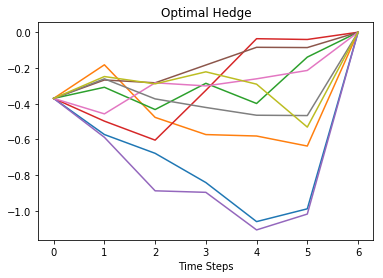

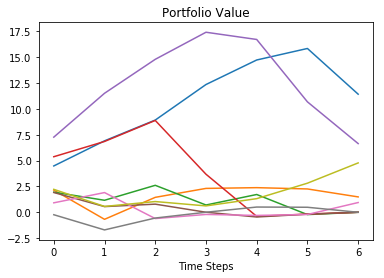

In [146]:
# plot 10 paths
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

Once the optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ are all computed, the reward function $R_t\left(X_t,a_t,X_{t+1}\right)$ could then be computed by

$$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=0,...,T-1$$

with terminal condition $R_T=-\lambda Var\left[\Pi_T\right]$.

Plot of 5 reward function $R_t$ paths is shown below.

## Part 2: Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$\omega_t=\mathbf C_t^{-1}\mathbf D_t$$

where $\mathbf C_t$ and $\mathbf D_t$ are matrix and vector respectively with elements given by

$$C_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)}\quad\quad D_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left(R_t\left(X_t,a_t^\star,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

Define function *function_C* and *function_D* to compute the value of matrix $\mathbf C_t$ and vector $\mathbf D_t$.

**Instructions:**
Copy-paste implementations from the previous assignment,i.e. QLBS as these are the same functions

In [147]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar
    
    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """
    ### START CODE HERE ### (≈ 5-6 lines of code)
    # C_mat = your code goes here ....
    X_mat = data_mat[t,:,:]
    num_basis_func = X_mat.shape[1]
    C_mat  = np.dot(X_mat.T,X_mat) + + reg_param * np.eye(num_basis_func) 
    
    
    ### END CODE HERE ###

    return C_mat

def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    
    Return:
    D_vec - np.array of dimension num_basis x 1
    """
    ### START CODE HERE ### (≈ 2-3 lines of code)
    # D_vec = your code goes here ...
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    
    ### END CODE HERE ###

    return D_vec

Call *function_C* and *function_D* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

Compare the QLBS price to European put price given by Black-Sholes formula.

$$C_t^{\left(BS\right)}=Ke^{-r\left(T-t\right)}\mathcal N\left(-d_2\right)-S_t\mathcal N\left(-d_1\right)$$

In [148]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price


## Hedging and Pricing with Reinforcement Learning

Implement a batch-mode off-policy model-free Q-Learning by Fitted Q-Iteration. The only data available is given by a set of $N_{MC}$ paths for the underlying state variable $X_t$, hedge position $a_t$, instantaneous reward $R_t$ and the next-time value $X_{t+1}$.

$$\mathcal F_t^k=\left\{\left(X_t^k,a_t^k,R_t^k,X_{t+1}^k\right)\right\}_{t=0}^{T-1}\quad k=1,...,N_{MC}$$

Detailed steps of solving the Bellman optimalty equation by Reinforcement Learning are illustrated below.

Expand Q-function in basis functions with time-dependent coefficients parametrized by a matrix $\mathbf W_t$.

$$Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf W_t\Phi\left(X_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)=\vec{W}_t^T \vec{\Psi}\left(X_t,a_t\right)$$

$$\mathbf A_t=\left(\begin{matrix}1\\a_t\\\frac{1}{2}a_t^2\end{matrix}\right)\quad\mathbf U_W\left(t,X_t\right)=\mathbf W_t\Phi\left(X_t\right)$$

where $\vec{W}_t$ is obtained by concatenating columns of matrix $\mathbf W_t$ while 
$ vec \left( {\bf \Psi} \left(X_t,a_t \right) \right) = 
  vec \, \left( {\bf A}_t  \otimes {\bf \Phi}^T(X) \right) $ stands for 
a vector obtained by concatenating columns of the outer product of vectors $ {\bf A}_t $ and $ {\bf \Phi}(X) $.

Compute vector $\mathbf A_t$ then compute $\vec\Psi\left(X_t,a_t\right)$ for each $X_t^k$ and store in a dictionary with key path and time $\left[k,t\right]$.

## Part 3: Make off-policy data

- **on-policy** data - contains an optimal action and the corresponding reward
- **off-policy** data - contains random action and the corresponding reward

Given a large enough sample, i.e. N_MC tending to infinity Q-Learner will learn an optimal policy from the data in a model-free setting.
In our case a random action is an optimal action + noise generated by sampling from uniform: distribution $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$

where $\eta$ is a disturbance level
In other words, each noisy action is calculated by taking optimal action computed previously and multiplying it by a uniform r.v. in the interval $\left[1-\eta, 1 + \eta\right]$

**Instructions:**
In the loop below:
 - Compute the optimal policy, and write the result to a_op
 - Now disturb these values by a random noise
 $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$
 - Compute portfolio values corresponding to observed actions
 $$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$
 - Compute rewards corrresponding to observed actions
 $$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=T-1,...,0$$
with terminal condition $$R_T=-\lambda Var\left[\Pi_T\right]$$

In [149]:
eta = 0.5 #  0.5 # 0.25 # 0.05 # 0.5 # 0.1 # 0.25 # 0.15
reg_param = 1e-3
np.random.seed(42) # Fix random seed

# disturbed optimal actions to be computed 
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):
    
    ### START CODE HERE ### (≈ 11-12 lines of code)
    
    # 1. Compute the optimal policy, and write the result to a_op
    a_op.loc[:,t] = a.loc[:,t]
    
    
    # 2. Now disturb these values by a random noise
    a_op.loc[:, t] = a_op.loc[:, t] * np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])
    
    # 3. Compute portfolio values corresponding to observed actions
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
    
    # 4. Compute rewards corrresponding to observed actions
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])
    
    ### END CODE HERE ###
  
print('done with backward loop!')

done with backward loop!


In [150]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
idx_row = np.random.randint(low=0, high=R_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=R_op.shape[1], size=10)

part_1 = list(R_op.loc[idx_row, idx_col].values.flatten())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)

R_op.loc[idx_row, idx_col].values.flatten()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -4.41648229e-02,  -1.11627835e+00,  -3.26618627e-01,
        -4.41648229e-02,   1.86629772e-01,  -3.26618627e-01,
        -3.26618627e-01,  -4.41648229e-02,  -1.91643174e+00,
         1.86629772e-01,  -4.41648229e-02,  -1.15471981e+01,
         8.36214406e-03,  -4.41648229e-02,  -5.19860756e-01,
         8.36214406e-03,   8.36214406e-03,  -4.41648229e-02,
        -5.82629891e-02,  -5.19860756e-01,  -4.41648229e-02,
        -2.93024596e+00,  -6.70591047e-01,  -4.41648229e-02,
         3.38303735e-01,  -6.70591047e-01,  -6.70591047e-01,
        -4.41648229e-02,  -1.35776224e-01,   3.38303735e-01,
        -4.41648229e-02,   3.89179538e-02,  -2.11256164e+00,
        -4.41648229e-02,  -8.62139383e-01,  -2.11256164e+00,
        -2.11256164e+00,  -4.41648229e-02,   1.03931641e+00,
        -8.62139383e-01,  -4.41648229e-02,  -3.88581528e+00,
        -2.78664643e-01,  -4.41648229e-02,   1.08026845e+00,
        -2.78664643e-01,  -2.78664643e-01,  -4.41648229e-02,
        -1.59815566e-01,

In [151]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
idx_row = np.random.randint(low=0, high=Pi_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=Pi_op.shape[1], size=10)

part_2 = list(Pi_op.loc[idx_row, idx_col].values.flatten())
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)

Pi_op.loc[idx_row, idx_col].values.flatten()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([  0.        ,   1.42884104,   0.33751419,   0.        ,
         1.21733506,   0.33751419,   0.33751419,   0.        ,
         3.11498207,   1.21733506,   0.        ,  11.42133749,
        -0.10310673,   0.        ,  11.86648425,  -0.10310673,
        -0.10310673,   0.        ,  11.85284966,  11.86648425,
         0.        ,   3.77013248,   0.86748124,   0.        ,
         3.39527529,   0.86748124,   0.86748124,   0.        ,
         3.50140426,   3.39527529,   0.        ,   2.37907167,
         2.45349463,   0.        ,   3.21159555,   2.45349463,
         2.45349463,   0.        ,   2.143548  ,   3.21159555,
         0.        ,   4.22816728,   0.36745282,   0.        ,
         3.10906092,   0.36745282,   0.36745282,   0.        ,
         3.24065673,   3.10906092,   0.        ,   1.4213709 ,
         2.79987609,   0.        ,   1.57224362,   2.79987609,
         2.79987609,   0.        ,   2.24072042,   1.57224362,
         9.05061694,   4.48960086,   5.90296866,   9.05

## Override on-policy data with off-policy data

In [152]:
# Override on-policy data with off-policy data
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

In [153]:
# make matrix A_t of shape (3 x num_MC x num_steps)
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

print(A_stack.shape)

(3, 10000, 7)


In [154]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape) # (12, 10000, 25)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,25)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,25)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
# Psi_mat = Psi_mat.reshape(-1, a.shape[0], a.shape[1], order='F')
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

print(Psi_mat.shape) #

(12, 10000, 7)
(36, 10000, 7)


In [155]:
# make matrix S_t 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

print(S_t_mat.shape)

(36, 1, 10000, 7) (1, 36, 10000, 7)
(36, 36, 7)


In [156]:
# clean up some space
del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2


## Part 4: Calculate $\mathbf S_t$ and $\mathbf M_t$ marix and vector
Vector $\vec W_t$ could be solved by

$$\vec W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\Psi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\left(R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

**Instructions:**
- implement function_S_vec() which computes $S_{nm}^{\left(t\right)}$ matrix
- implement function_M_vec() which computes $M_n^{\left(t\right)}$ column vector

In [157]:
# vectorized functions

def function_S_vec(t, S_t_mat, reg_param):
    """
    function_S_vec - calculate S_{nm} matrix from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t - time index, a scalar, an index into time axis of S_t_mat 
    S_t_mat - pandas.DataFrame of dimension num_Qbasis x num_Qbasis x T
    reg_param - regularization parameter, a scalar
    Return:
    S_mat_reg - num_Qbasis x num_Qbasis
    """
    ### START CODE HERE ### (≈ 4-5 lines of code)
    # S_mat_reg = your code goes here ...    
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)
    
    ### END CODE HERE ###
    return S_mat_reg
   
def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, 
                   gamma=gamma):
    """
    function_S_vec - calculate M_{nm} vector from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t- time index, a scalar, an index into time axis of S_t_mat 
    Q_star - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    Psi_mat_t - pandas.DataFrame of dimension num_Qbasis x N_MC
    gamma - one time-step discount factor $exp(-r \delta t)$
    Return:
    M_t - np.array of dimension num_Qbasis x 1
    """
    ### START CODE HERE ### (≈ 2-3 lines of code)
    # M_t = your code goes here ...
    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])
    ### END CODE HERE ###

    return M_t

In [158]:
### GRADED PART (DO NOT EDIT) ###
reg_param = 1e-3
np.random.seed(42)
S_mat_reg = function_S_vec(T-1, S_t_mat, reg_param) 
idx_row = np.random.randint(low=0, high=S_mat_reg.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=S_mat_reg.shape[1], size=10)

part_3 = list(S_mat_reg[idx_row, idx_col].flatten())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)

S_mat_reg[idx_row, idx_col].flatten()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([  2.22709265e-01,   2.68165972e+02,   4.46911166e+01,
         2.00678517e+00,   1.10020457e+03,   8.44758984e-01,
         2.29671816e+02,   2.29671816e+02,   3.78571544e-03,
         1.41884196e-02])

In [159]:
### GRADED PART (DO NOT EDIT) ###
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

M_t = function_M_vec(T-1, Q_star, R, Psi_mat[:,:,T-1], gamma)

part_4 = list(M_t)
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)

M_t
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -6.03245979e+01,  -8.79998437e+01,  -2.37497369e+02,
        -5.62543448e+02,   2.09052583e+02,  -6.44961368e+02,
        -2.86243249e+03,   2.77687723e+03,  -1.85728309e+03,
        -9.40505558e+03,   9.50610806e+03,  -5.29328413e+03,
        -1.69800964e+04,   1.61026240e+04,  -8.42698927e+03,
        -8.46211901e+03,   6.05144701e+03,  -2.62196067e+03,
        -2.12066484e+03,   8.42176836e+02,  -2.51624368e+02,
        -3.01116012e+02,   2.57124667e+01,  -3.22639691e+00,
        -5.53769815e+01,   1.67390280e+00,  -6.79562288e-02,
        -1.61140947e+01,   1.16524075e+00,  -1.49934348e-01,
        -9.79117274e+00,  -7.22309330e-02,  -4.70108927e-01,
        -6.87393130e+00,  -2.10244341e+00,  -7.70293521e-01])

Call *function_S* and *function_M* for $t=T-1,...,0$ together with vector $\vec\Psi\left(X_t,a_t\right)$ to compute $\vec W_t$ and learn the Q-function $Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)$ implied by the input data backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

When the vector $ \vec{W}_t $ is computed as per the above at time $ t $, 
we can convert it back to a matrix $ \bf{W}_t $ obtained from the vector $ \vec{W}_t $ by 
reshaping to the shape $ 3 \times M $.

We can now calculate the matrix $ {\bf U}_t $
at time $ t $ for the whole set of MC paths as follows (this is Eq.(65) from the paper in a matrix form):

$$  \mathbf U_{W} \left(t,X_t \right) = 
\left[\begin{matrix} \mathbf U_W^{0,k}\left(t,X_t \right) \\  
\mathbf U_W^{1,k}\left(t,X_t \right) \\ \mathbf U_W^{2,k} \left(t,X_t \right)
\end{matrix}\right]
= \bf{W}_t \Phi_t \left(t,X_t \right)  $$

Here the matrix $ {\bf \Phi}_t $ has the shape shape $ M \times N_{MC}$. 
Therefore, their dot product has dimension $ 3 \times N_{MC}$, as it should be. 

Once this matrix $ {\bf U}_t $ is computed, individual vectors $ {\bf U}_{W}^{1}, {\bf U}_{W}^{2}, {\bf U}_{W}^{3} $ for all MC paths are read off as rows of this matrix.

From here, we can compute the optimal action and optimal Q-function $Q^{\star}(X_t, a_t^{\star}) $ at the optimal action for a given step $ t $. This will be used to evaluate the $ \max_{a_{t+1} \in \mathcal{A}} Q^{\star} \left(X_{t+1}, a_{t+1} \right) $.


The optimal action and optimal Q-function with the optimal action could be computed by

$$a_t^\star\left(X_t\right)=\frac{\mathbb{E}_{t} \left[  \Delta \hat{S}_{t}  \hat{\Pi}_{t+1} + \frac{1}{2 \gamma \lambda} \Delta S_{t} \right]}{
  \mathbb{E}_{t} \left[ \left( \Delta \hat{S}_{t} \right)^2 \right]}\, , 
\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\mathbf U_W^{\left(0\right)}\left(t,X_t\right)+ a_t^\star \mathbf U_W^{\left(2\right)}\left(t,X_t\right) +\frac{1}{2}\left(a_t^\star\right)^2\mathbf U_W^{\left(2\right)}\left(t,X_t\right)$$

with terminal condition $a_T^\star=0$ and $Q_T^\star\left(X_T,a_T^\star=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

Plots of 5 optimal action $a_t^\star\left(X_t\right)$, optimal Q-function with optimal action $Q_t^\star\left(X_t,a_t^\star\right)$ and implied Q-function $Q_t^\star\left(X_t,a_t\right)$ paths are shown below.

## Fitted Q Iteration (FQI)

In [160]:
starttime = time.time()

# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

# max_Q_star_next = Q_star.iloc[:,-1].values 
max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):
    
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    # IMPORTANT!!! Instead, use hedges computed as in DP approach:
    # in this way, errors of function approximation do not back-propagate. 
    # This provides a stable solution, unlike
    # the first method that leads to a diverging solution 
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)
    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 

    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
    # update dataframes     
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # print('t = %s low_perc_Q_RL = %s up_perc_Q_RL = %s' % (t, low_perc_Q_RL, up_perc_Q_RL))
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
    
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Time Cost: 1.3747336864471436 seconds


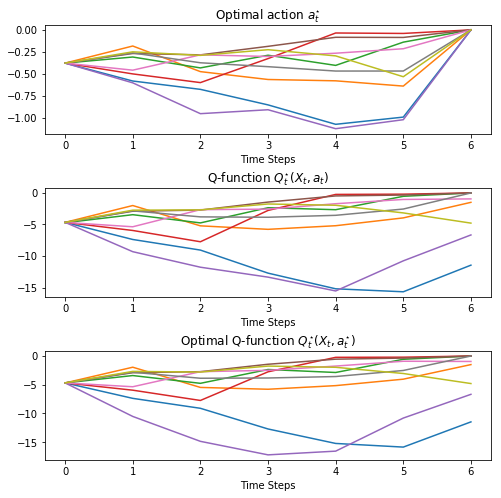

In [162]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()

Compare the optimal action $a_t^\star\left(X_t\right)$ and optimal Q-function with optimal action $Q_t^\star\left(X_t,a_t^\star\right)$ given by Dynamic Programming and Reinforcement Learning.

Plots of 1 path comparisons are given below.

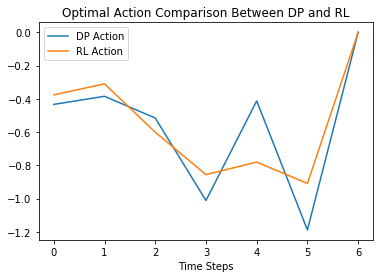

In [163]:
# plot a and a_star
# plot 1 path

num_path =  120 # 240 # 260 #  300 # 430 #  510

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()

## Summary of the RL-based pricing with QLBS

In [164]:
# QLBS option price
C_QLBS = - Q_star.copy() # Q_RL # 

print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')

# # plot one path
# plt.plot(C_QLBS.T.iloc[:,[200]])
# plt.xlabel('Time Steps')
# plt.title('QLBS RL Option Price')
# plt.show()

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.03
Risk aversion parameter : 0.001
Strike:                   100
Maturity:                 1

The QLBS Put Price 1 :    4.7040

Black-Sholes Put Price:   4.5296




In [165]:
### GRADED PART (DO NOT EDIT) ###

part5 = str(C_QLBS.iloc[0,0])
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:5],all_parts,submissions)
C_QLBS.iloc[0,0]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


4.7039669495341006

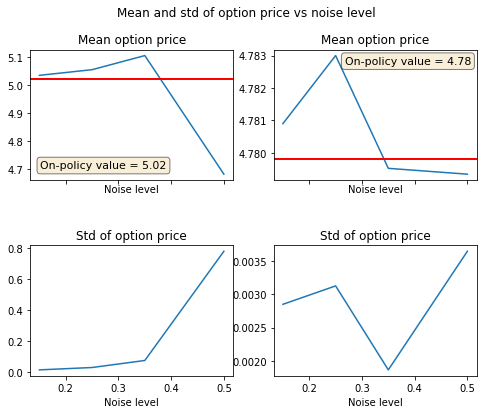

In [166]:
# add here calculation of different MC runs (6 repetitions of action randomization)

# on-policy values
y1_onp = 5.0211 # 4.9170
y2_onp = 4.7798 # 7.6500

# QLBS_price_on_policy = 4.9004 +/- 0.1206

# these are the results for noise eta = 0.15
# p1 = np.array([5.0174, 4.9249, 4.9191, 4.9039, 4.9705, 4.6216 ])
# p2 = np.array([6.3254, 8.6733, 8.0686, 7.5355, 7.1751, 7.1959 ])

p1 = np.array([5.0485, 5.0382, 5.0211, 5.0532, 5.0184])
p2 = np.array([4.7778, 4.7853, 4.7781,4.7805, 4.7828])

# results for eta = 0.25
# p3 = np.array([4.9339, 4.9243, 4.9224, 5.1643, 5.0449, 4.9176 ])
# p4 = np.array([7.7696,8.1922, 7.5440,7.2285, 5.6306, 12.6072])

p3 = np.array([5.0147, 5.0445, 5.1047, 5.0644, 5.0524])
p4 = np.array([4.7842,4.7873, 4.7847, 4.7792, 4.7796])

# eta = 0.35 
# p7 = np.array([4.9718, 4.9528, 5.0170, 4.7138, 4.9212, 4.6058])
# p8 = np.array([8.2860, 7.4012, 7.2492, 8.9926, 6.2443, 6.7755])

p7 = np.array([5.1342, 5.2288, 5.0905, 5.0784, 5.0013 ])
p8 = np.array([4.7762, 4.7813,4.7789, 4.7811, 4.7801])

# results for eta = 0.5
# p5 = np.array([4.9446, 4.9894,6.7388, 4.7938,6.1590, 4.5935 ])
# p6 = np.array([7.5632, 7.9250, 6.3491, 7.3830, 13.7668, 14.6367 ])

p5 = np.array([3.1459, 4.9673, 4.9348, 5.2998, 5.0636 ])
p6 = np.array([4.7816, 4.7814, 4.7834, 4.7735, 4.7768])

# print(np.mean(p1), np.mean(p3), np.mean(p5))
# print(np.mean(p2), np.mean(p4), np.mean(p6))
# print(np.std(p1), np.std(p3), np.std(p5))
# print(np.std(p2), np.std(p4), np.std(p6))

x = np.array([0.15, 0.25, 0.35, 0.5])
y1 = np.array([np.mean(p1), np.mean(p3), np.mean(p7), np.mean(p5)])
y2 = np.array([np.mean(p2), np.mean(p4), np.mean(p8), np.mean(p6)])
y_err_1 = np.array([np.std(p1), np.std(p3),np.std(p7),  np.std(p5)])
y_err_2 = np.array([np.std(p2), np.std(p4), np.std(p8), np.std(p6)])

# plot it 
f, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

f.subplots_adjust(hspace=.5)
f.set_figheight(6.0)
f.set_figwidth(8.0)

ax = axs[0,0]
ax.plot(x, y1)
ax.axhline(y=y1_onp,linewidth=2, color='r')
textstr = 'On-policy value = %2.2f'% (y1_onp)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.05, 0.15, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_title('Mean option price')
ax.set_xlabel('Noise level')

ax = axs[0,1]
ax.plot(x, y2)
ax.axhline(y=y2_onp,linewidth=2, color='r')
textstr = 'On-policy value = %2.2f'% (y2_onp)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.35, 0.95, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_title('Mean option price')
ax.set_xlabel('Noise level')

ax = axs[1,0]
ax.plot(x, y_err_1)
ax.set_title('Std of option price')
ax.set_xlabel('Noise level')

ax = axs[1,1]
ax.plot(x, y_err_2)
ax.set_title('Std of option price')
ax.set_xlabel('Noise level')

f.suptitle('Mean and std of option price vs noise level')

plt.savefig('Option_price_vs_noise_level.png', dpi=600)
plt.show()